## Importing

In [174]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV

## Loading data

In [114]:
def read_data(filename):
    df = pd.read_csv(filename)
    df = df.rename(columns={'spacegroup': 'sg',
                            'number_of_total_atoms': 'Natoms',
                            'percent_atom_al': 'xAl',
                            'percent_atom_ga': 'xGa',
                            'percent_atom_in': 'xIn',
                            'lattice_vector_1_ang': 'a',
                            'lattice_vector_2_ang': 'b',
                            'lattice_vector_3_ang': 'c',
                            'lattice_angle_alpha_degree': 'alpha',
                            'lattice_angle_beta_degree': 'beta',
                            'lattice_angle_gamma_degree': 'gamma',
                            'formation_energy_ev_natom': 'Ef',
                            'bandgap_energy_ev': 'Eg'})
    return df

In [115]:
train = read_data('./train.csv')
test = read_data('./test.csv')
full = [train, test] 

vector_labels = ['a', 'b', 'c']
angle_labels = ['alpha', 'beta', 'gamma']
composition_labels = ['xAl', 'xGa', 'xIn']

## Data Exploration

### Spacegroups
Check which spacegroups train and test sets contain.

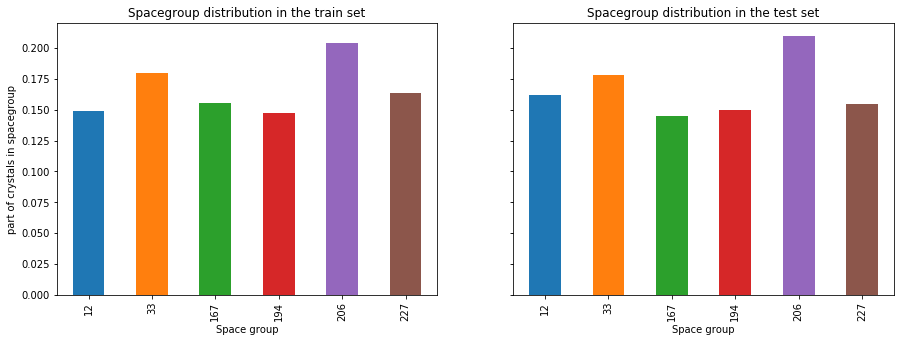

In [116]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
titles = [f'Spacegroup distribution in the {i} set' for i in ['train', 'test']]

for i in range(2):
    full[i]['sg'].value_counts(normalize=True).sort_index().plot.bar(ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Space group')
ax[0].set_ylabel('part of crystals in spacegroup')
plt.show()

Train and test sets have the same spacegroups.

### Number of atoms

Train set:

In [117]:
pd.crosstab(train['Natoms'], train['sg'])

sg,12,33,167,194,206,227
Natoms,,,,,,
10.0,0,0,0,13,0,0
20.0,84,0,0,0,0,0
30.0,0,0,326,0,0,0
40.0,0,126,0,0,0,393
60.0,0,0,48,0,0,0
80.0,274,306,0,340,490,0


Test set:

In [118]:
pd.crosstab(test['Natoms'], test['sg'])

sg,12,33,167,194,206,227
Natoms,,,,,,
10.0,0,0,0,7,0,0
20.0,27,0,0,0,0,0
30.0,0,0,73,0,0,0
40.0,0,30,0,0,0,93
60.0,0,0,14,0,0,0
80.0,70,77,0,83,126,0


### Lattice angles

In [119]:
train.groupby('sg')[angle_labels].describe().xs(slice('mean', 'std'), level=1, axis=1)

,alpha,alpha,beta,beta,gamma,gamma
sg,,,,,,
12,89.999838,0.000290,104.572380,0.525823,90.000112,0.000058
33,90.001709,0.002258,90.000445,0.001798,90.000840,0.000513
167,89.993366,0.004110,90.007081,0.004660,120.001058,0.000466
194,90.011335,0.006336,90.002652,0.005360,119.995280,0.005568
206,90.002605,0.001459,90.002776,0.001347,89.997340,0.001613
227,91.479187,3.009116,91.362545,3.328180,63.746595,43.309462


In [120]:
test.groupby('sg')[angle_labels].describe().xs(slice('mean', 'std'), level=1, axis=1)

,alpha,alpha,beta,beta,gamma,gamma
sg,,,,,,
12,89.999853,0.000296,104.560765,0.538130,90.000115,0.000053
33,90.001598,0.002282,90.000267,0.001955,90.000840,0.000530
167,89.993017,0.004548,90.007460,0.005040,120.001075,0.000513
194,90.010834,0.006072,90.003639,0.006037,119.996086,0.005977
206,90.002587,0.001451,90.002714,0.001352,89.997291,0.001588
227,91.043244,2.422655,90.836886,2.506604,73.757023,45.023798


All spacegroups have small deviation of angles, except 227. Also beta angle from spacegroup 12 have significant deviation. 

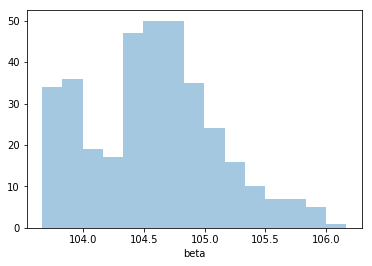

In [121]:
sns.distplot(train[train['sg']==12]['beta'], kde=False, bins=15)

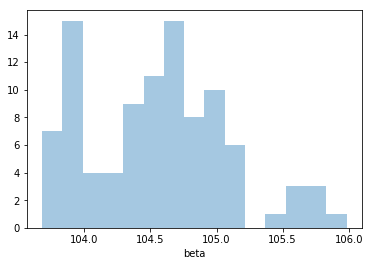

In [122]:
sns.distplot(test[test['sg']==12]['beta'], kde=False, bins=15)

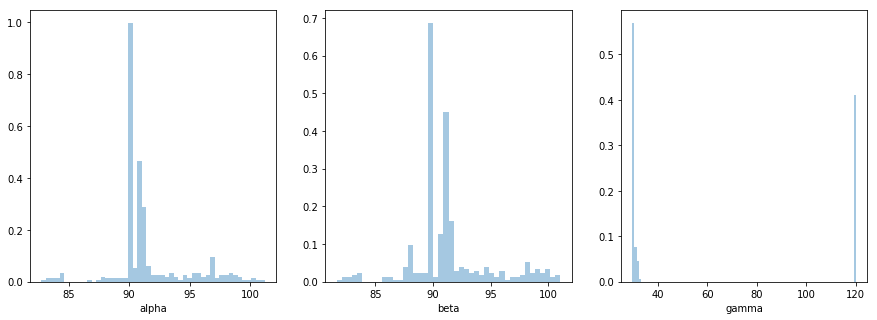

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
bins = [None, None, 100]
for i, angle in enumerate(angle_labels):
    sns.distplot(train[train['sg']==227][angle], ax=ax[i], kde=False, norm_hist=True, bins=bins[i])

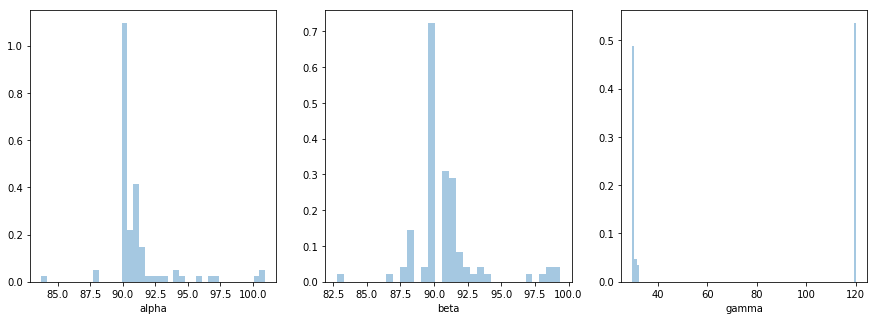

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
bins = [None, None, 100]
for i, angle in enumerate(angle_labels):
    sns.distplot(test[test['sg']==227][angle], ax=ax[i], kde=False, norm_hist=True, bins=bins[i])

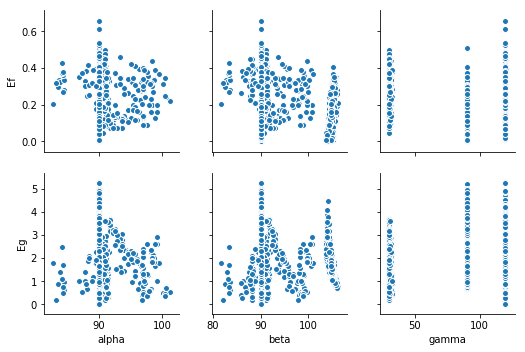

In [125]:
sns.pairplot(train, x_vars=angle_labels, y_vars=['Ef', 'Eg'])

### Lattice vectors

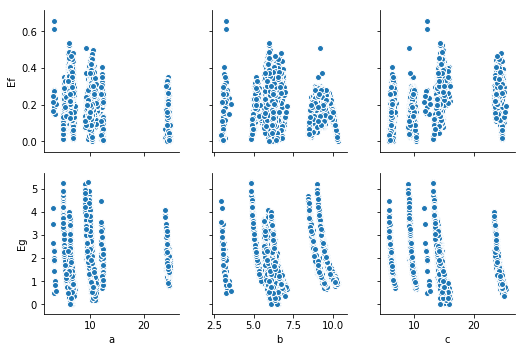

In [126]:
sns.pairplot(train, x_vars=vector_labels, y_vars=['Ef', 'Eg'])

### Composition

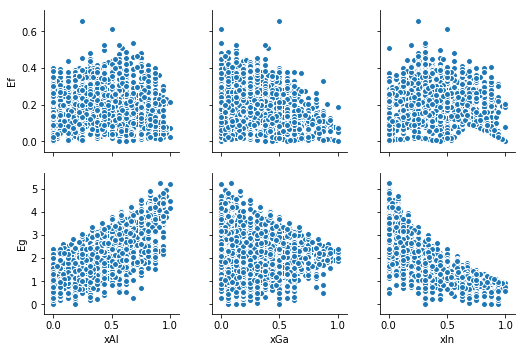

In [127]:
sns.pairplot(train, x_vars=composition_labels, y_vars=['Ef', 'Eg'])

## Feature Engineering

Add feature degree of tetragonality:

In [128]:
for ds in full:
    ds['tetra'] = ds['c'] / ds['a']

Degree to radian:

In [148]:
for ds in full:
    for angle in angle_labels:
        ds[angle] = np.radians(ds[angle])

Volume of cell:

In [154]:
for ds in full:
    vector_product = ds[vector_labels].product(axis=1)
    angle_product = ds[angle_labels].product(axis=1)
    cos_angle_pow = ds[angle_labels].apply(np.cos).pow(2)
    ds['V'] = vector_product * (1 + 2 * np.cos(angle_product) - (cos_angle_pow.sum(axis=1))).apply(np.sqrt)
    ds['density'] = ds['Natoms'] / ds['V']

Checking correlation map:

In [155]:
for ds in full: # for categorizing
    ds['sg'] = ds['sg'].astype(int)
    ds['Natoms'] = ds['Natoms'].astype(int)

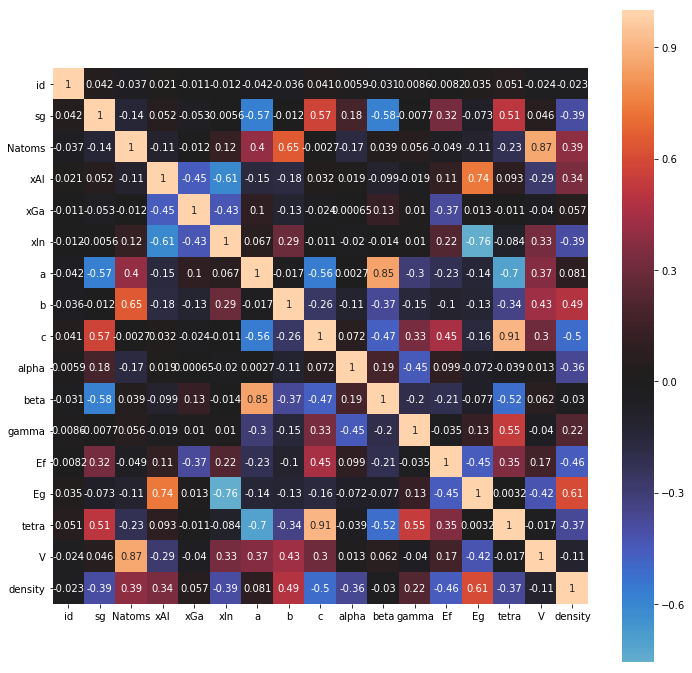

In [156]:
plt.figure(figsize=(12, 12))
sns.heatmap(train.corr(), center=0, square=True, annot=True)

In [176]:
X_train = train.drop(labels=['Ef', 'Eg', 'id'], axis=1).values
X_test = test.drop(labels=['id'], axis=1).values
Y_train = train[['Ef', 'Eg']].values

## Building model

### Polynomial model

In [198]:
enc = OneHotEncoder(categorical_features=[0, 1])
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
tsvd = TruncatedSVD()
reg_ridge = Ridge(normalize=True)

features = FeatureUnion([('enc', enc), ('poly', poly)])
pipe = Pipeline([('features', features), ('tsvd', tsvd), ('rgr', rgr)])

param_grid = dict(tsvd__n_components=[50, 60, 70, 80], rgr__alpha=[0.005, 0.01, 0.05])

estimator = GridSearchCV(pipe,
                         param_grid=param_grid,
                         return_train_score=True,
                         cv=5,
                         scoring='neg_mean_squared_log_error',
                         n_jobs=-1)
estimator.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('enc', OneHotEncoder(categorical_features=[0, 1], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)), ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False))],
  ...fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tsvd__n_components': [50, 60, 70, 80], 'rgr__alpha': [0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_log_error', verbose=0)

In [199]:
estimator.cv_results_['mean_test_score'], estimator.cv_results_['std_test_score']

(array([-0.00477174, -0.00452245, -0.00457976, -0.0048647 , -0.00476726,
        -0.00452778, -0.00458381, -0.0048661 , -0.00485199, -0.00467629,
        -0.00472287, -0.00498551]),
 array([ 0.00040197,  0.00025848,  0.00039365,  0.00080095,  0.00039274,
         0.00025942,  0.00039415,  0.00080004,  0.00036235,  0.00027583,
         0.00040944,  0.00080147]))

In [200]:
estimator.best_params_

{'rgr__alpha': 0.005, 'tsvd__n_components': 60}

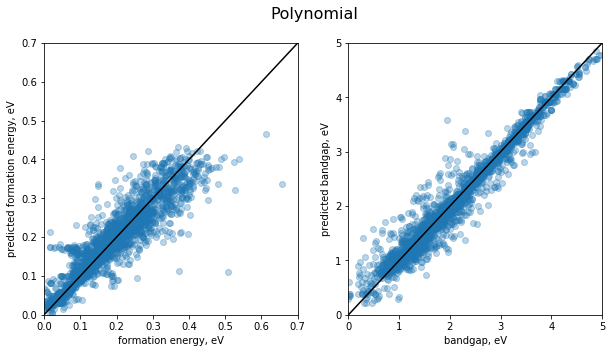

In [213]:
def plot_targets(estimator, title=None):
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    lim = [(0, 0.7), (0, 5)]
    for i in range(2):
        ax[i].plot([0, 5], [0, 5], color='black')
        ax[i].scatter(Y_train[:, i], estimator.predict(X_train)[:, i], alpha=0.3, )
        ax[i].set_xlim(lim[i])
        ax[i].set_ylim(lim[i])
    ax[0].set_xlabel('formation energy, eV')
    ax[1].set_xlabel('bandgap, eV')
    ax[0].set_ylabel('predicted formation energy, eV')
    ax[1].set_ylabel('predicted bandgap, eV')
    plt.suptitle(title, fontsize=16)
plot_targets(estimator, 'Polynomial')

### RandomForest

In [203]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor

reg_rf = RandomForestRegressor()

param_grid_rf = dict(reg_rf__n_estimators=[50, 75, 100, 125, 150],
                     reg_rf__max_depth=[4, 6, 8])

pipe_rf = Pipeline([('enc', enc), ('reg_rf', reg_rf)])
grid_rf = GridSearchCV(pipe_rf,
                       param_grid=param_grid_rf,
                       scoring='neg_mean_squared_log_error',
                       cv=5,
                       n_jobs=-1)

grid_rf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('enc', OneHotEncoder(categorical_features=[0, 1], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)), ('reg_rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           mi...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg_rf__n_estimators': [50, 75, 100, 125, 150], 'reg_rf__max_depth': [4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=0)

In [204]:
grid_rf.cv_results_['mean_test_score'], grid_rf.cv_results_['std_test_score']

(array([-0.00892002, -0.00873498, -0.00877245, -0.00879555, -0.00876724,
        -0.00589457, -0.0058293 , -0.00589971, -0.00588306, -0.00584269,
        -0.00519164, -0.00515512, -0.00517675, -0.00516652, -0.00519317]),
 array([ 0.00033004,  0.00037979,  0.00037096,  0.00037011,  0.00041101,
         0.00041301,  0.00038375,  0.00036802,  0.00036398,  0.00039283,
         0.00026717,  0.00037957,  0.0003287 ,  0.00030788,  0.0003954 ]))

In [205]:
grid_rf.best_score_

-0.0051551204401689386

In [217]:
grid_rf.best_params_

{'reg_rf__max_depth': 8, 'reg_rf__n_estimators': 75}

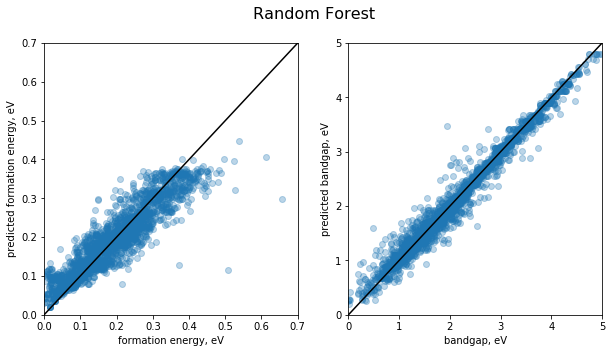

In [214]:
plot_targets(grid_rf, 'Random Forest')

In [216]:
reg_rf.feature_importances_

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Submit Prediction

In [30]:
y_pred = estimator.predict(X_test)
submit = pd.DataFrame({'id':test['id'],
                       'formation_energy_ev_natom':y_pred[:, 0],
                       'bandgap_energy_ev':y_pred[:, 1]},
                      columns=['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'])
submit.to_csv('rg_conductor.csv', index=False)
submit.head()

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.188223,1.593413
1,2,0.080842,3.712503
2,3,0.158815,3.485023
3,4,0.040651,3.010816
4,5,0.114291,1.651810


In [31]:
!head rg_conductor.csv

id,formation_energy_ev_natom,bandgap_energy_ev
1,0.18822307519281223,1.5934133966569153
2,0.08084241117327966,3.7125025117339283
3,0.1588145385489355,3.485023284268559
4,0.04065088899115721,3.0108163893109747
5,0.11429096079647827,1.6518096016461685
6,0.04872892713606686,4.334478706883306
7,0.07235590885716367,3.2195730536981344
8,0.11759483769124487,2.0840186556725766
9,0.07997547689720638,2.661187691893757
